<a href="https://colab.research.google.com/github/eduardodpms/cis_trainee_clus/blob/main/CIS_Trainee_Clu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Trainee CIS (2° Período) - Clusterização***

Informações do *Trainee*:

- **Nome**: Eduardo de Pina Moreira Santos
- **Matrícula**: 231034494
- **Curso**: Engenharia de Software (FCTE)
- **E-mail**: eduardopms19@hotmail.com
- **Telefone**: (62)9 9994-1250

## **1. Introdução**

Este trabalho corresponde à atividade do 2° período do *Trainee* do capítulo estudantil da [*Computational Intelligence Society*](https://cis.ieee.org) do *IEEE*, na [Universidade de Brasília](https://www.unb.br). Demais informações do *Trainee* estão disponíveis no [*GitHub*](https://github.com/UnB-CIS/Trainee/tree/main). O foco dessa atividade é a elaboração de um modelo de aprendizado não-supervisionado, utilizando bibliotecas do [*Python*](https://www.python.org) como [*Pandas*](https://pandas.pydata.org), [*Matplotlib*](https://matplotlib.org), [*seaborn*](https://seaborn.pydata.org), [*scikit-learn*](https://scikit-learn.org) e [*NumPy*](https://numpy.org). O *Dataset* de treino é o [*Student Habits vs Academic Performance*](https://www.kaggle.com/datasets/jayaantanaath/student-habits-vs-academic-performance), disponível no [*Kaggle*](https://www.kaggle.com).

O *dataset* traz 1.000 tuplas relacionadas a 15 atributos acadêmicos que afetam (ou não) a nota dos estudantes em um teste (totalizando 16 variáveis). O objetivo da atividade é o desenvolvimento e otimização de um modelo de aprendizado não-supervisionado de clusterização do tipo ***K-Means*** *from scratch*, a fim de testar as habilidades do aluno no que tange à análise de dados, à clusterização e à abordagem desse modelo.

## **2. Investigação do *Dataset***

### 2.1. Importação de Bibliotecas e Definição de Classes

In [ ]:
# Importação das bibliotecas necessárias
import pandas as pd # Manipulação de arquivos
import matplotlib.pyplot as plt # Geração de figuras
import matplotlib.colors # Manipulação de cores
import seaborn as sns # Visualização estatística
import numpy as np # Manipulação de arrays

In [ ]:
# Classe para visualização de métricas referentes aos atributos do DataSet
class DataView():
  # Método de inicialização da classe
  def __init__(self, df, show_dim, categoricals, sequence, highlight_cols, inclusions):
    self.df = df # DataFrame a ser analisado
    self.show_dim = show_dim # Exibição das dimensões do DataFrame
    self.categoricals = categoricals # Inclusão de colunas categóricas
    self.sequence = sequence # Sequência de ordenação das colunas
    self.highlight_cols = highlight_cols # Colunas numéricas a destacar com gradiente
    self.inclusions = inclusions # Dicionário com métricas a incluir na visualização
    self.num_cols = self.df.select_dtypes(include='number').columns # Colunas numéricas do DataFrame

  # Método para definição das métricas desejadas
  def metrics(self):
    stats = pd.DataFrame(index=self.inclusions.keys(), columns=self.df.columns) # Cria um Dataframe vazio, com as mesmas características do original

    for col in stats.columns:
      stats.loc[['data_type', 'mode'], col] = [self.df[col].dtype, self.df[col].mode().iloc[0]] # Atribui o tipo dos dados e a moda
      stats.loc[['null_count', 'n_unique'], col] = [self.df[col].isnull().sum(), self.df[col].nunique()] # Atribui a contagem de Null e de valores únicos

      if col in self.num_cols: # Caso as variáveis sejam numéricas
        stats.loc[['type', 'zero_count'], col] = ['Numerical', (self.df[col] == 0).sum()] # Atribui o tipo do atributo e a contagem de zeros
        stats.loc[['mean', 'std', 'min', 'max'], col] = [self.df[col].mean(), self.df[col].std(), self.df[col].min(), self.df[col].max()] # Atribui média, desvio-padrão, min e máx
        stats.loc[['q1', 'median', 'q3'], col] = [self.df[col].quantile(0.25), self.df[col].median(), self.df[col].quantile(0.75)] # Atribui os quartis 1, 2 e 3

        iqr = stats.loc['q3', col] - stats.loc['q1', col] # Calcula o índice iqr com base nos quartis
        stats.loc['outliers_low', col] = (self.df[col] < (stats.loc['q1', col] - 1.5 * iqr)).sum() # Atribui a contagem de outliers menores que o primeiro quartil
        stats.loc['outliers_high', col] = (self.df[col] > (stats.loc['q3', col] + 1.5 * iqr)).sum() # Atribui a contagem de outliers maiores que o segund quartil
        stats.loc['outliers_total', col] = stats.loc['outliers_low', col] + stats.loc['outliers_high', col] # Atribui a contagem total de outliers

      else: # Caso as variáveis sejam categóricas
        stats.loc['type', col] = 'Categorical' # Define a string que caracteriza o tipo
        stats.loc[['zero_count', 'mean', 'std', 'min', 'max', 'q1', 'median', 'q3'], col] = np.nan # Define os dados numéricos como NaN

    included_metrics = [key for key, value in self.inclusions.items() if value] # Lista de atributos a retornar
    included_atributes = stats.columns if self.categoricals else self.num_cols

    if self.sequence[0] in self.inclusions.keys(): # Verifica se a key de ordenação é válida
      included_atributes = sorted(included_atributes, key=lambda x: stats.loc[self.sequence[0], x], reverse=self.sequence[1]) # Ordena os atributos
    elif self.sequence[0] != 'default': # Verifica se a key de ordenação é inválida e diferente de "default"
      print(f"\nWARNING: Invalid sorting atribute. Using default sorting.\n") # Exibe um warning e não ordena os atributos

    return stats.loc[included_metrics, included_atributes].T # Retorna o DataFrame com as métricas e ordenação desejadas

  # Método para visualização das métricas desejadas em forma de tabela
  def show(self):
    stats = self.metrics() # Gera as métricas

    if self.show_dim: # Caso a exibição de dimensões tenha sido habilitada
      print(f"Dimensions: {self.df.shape[0]} rows X {self.df.shape[1]} columns") # Exibe as dimensões do DataFrame

    for col in self.highlight_cols: # Loop para evitar erros durante a seleção de highlights com gradiente
      if (col not in stats.columns) or (col in ['type', 'data_type', 'mode']): # Se não foi selecionada ou não é numérica
        return print(f"\nWARNING: Invalid highlighted metrics selection ('{col}').\n\n{stats}") # Gera um warning e exibe uma tabela simplificada

    # Retorna o Styler com formatação e gradiente visual
    return stats.style\
      .background_gradient(cmap='YlGnBu', subset=self.highlight_cols)\
      .format(na_rep='-', precision=2)\
      .set_caption("DataFrame's Atributes Metrics")

A classe *DataView* é um modelo personalizado de exibição de métricas referentes ao *DataFrame*. Em uma mesma tabela, ela relaciona métricas como média, desvio padrão, quartis e contagem de outliers com cada atributo do *Dataset*, além de permitir a inclusão de atributos categóricos na exibição. Seu objetivo é aprofundar a investigação de maneira simples, porém rica.

### 2.2. Importação e Abordagem do *Dataset*

In [ ]:
# Importação e visualização do dataset
data = pd.read_csv(filepath_or_buffer='student_habits_performance.csv') # Tranfere o conjunto de dados para um Dataframe, com o auxílio da biblioteca Pandas

print(f'{data.to_string(max_rows=18, show_dimensions=True)}') # Apresenta as n primeiras e n últimas linhas da relação

    student_id  age  gender  study_hours_per_day  social_media_hours  netflix_hours part_time_job  attendance_percentage  sleep_hours diet_quality  exercise_frequency parental_education_level internet_quality  mental_health_rating extracurricular_participation  exam_score
0        S1000   23  Female                  0.0                 1.2            1.1            No                   85.0          8.0         Fair                   6                   Master          Average                     8                           Yes        56.2
1        S1001   20  Female                  6.9                 2.8            2.3            No                   97.3          4.6         Good                   6              High School          Average                     8                            No       100.0
2        S1002   21    Male                  1.4                 3.1            1.3            No                   94.8          8.0         Poor                   1              H

Uma análise rápida da prévia da relação, com a utilização do método `to_string` permite inferir os seguintes itens:

- A relação é composta por **1.000 tuplas** (0-999) e por **16 atributos**;
- O *Dataset* contém **9 atributos numéricos** (int ou float) e **7 atributos categóricos** (strings).

In [ ]:
# Criação do objeto para visualização das métricas
data_view = DataView(df=data, # Atribuição do DataFrame contendo o DataSet
                     show_dim = True, # Exibição das dimensões do DataFrame
                     categoricals = True, # Inclusão de colunas categóricas
                     sequence = ('type', True), # Sequência de ordenação das colunas
                     highlight_cols = ['outliers_total'], # Colunas *numéricas* a destacar com gradiente
                     inclusions = {'type': True, 'data_type': True, 'null_count': True, 'zero_count': True, # Dicionário com as métricas desejadas
                                 'mean': True, 'std': True, 'min': True, 'max': True,
                                 'q1': True, 'median': True, 'q3': True, 'n_unique': True, 'mode': True,
                                 'outliers_low': False, 'outliers_high': False, 'outliers_total': True,})

data_view.show() # Plota a tabela com o método "show"

Dimensions: 1000 rows X 16 columns


,type,data_type,null_count,zero_count,mean,std,min,max,q1,median,q3,n_unique,mode,outliers_total
age,Numerical,int64,0,0,20.50,2.31,17,24,18.75,20.00,23.00,8,20,0
study_hours_per_day,Numerical,float64,0,13,3.55,1.47,0.00,8.30,2.60,3.50,4.50,78,3.50,7
social_media_hours,Numerical,float64,0,21,2.51,1.17,0.00,7.20,1.70,2.50,3.30,60,3.10,5
netflix_hours,Numerical,float64,0,59,1.82,1.08,0.00,5.40,1.00,1.80,2.52,51,0.00,4
attendance_percentage,Numerical,float64,0,0,84.13,9.40,56.00,100.00,78.00,84.40,91.03,320,100.00,3
sleep_hours,Numerical,float64,0,0,6.47,1.23,3.20,10.00,5.60,6.50,7.30,68,6.50,2
exercise_frequency,Numerical,int64,0,144,3.04,2.03,0,6,1.00,3.00,5.00,7,3,0
mental_health_rating,Numerical,int64,0,0,5.44,2.85,1,10,3.00,5.00,8.00,10,4,0
exam_score,Numerical,float64,0,0,69.60,16.89,18.40,100.00,58.48,70.50,81.33,480,100.00,2
student_id,Categorical,object,0,-,-,-,-,-,-,-,-,1000,S1000,-


Com o método `view`, foi possível observar algumas características importantes referentes a cada atributo. Dentre elas, é válido observar:

- Nenhum dos atributos parece se destacar no que tange à quantidade de *outliers*. Isso significa que não necessitarão de tratamento especial;
- Apenas o atributo `parental_educational_level` possui valores `Null`. Entretanto, estes não são dados faltantes, e sim etiquetas para indivíduos que não receberam diploma. Por questões de padronização, estes valores serão substituídos pela string `No Degree`;
- O atributo `student_id`, referente ao ID único de cada aluno, não apresenta um padrão e, por essa razão, não trará nenhuma vantagem para a atividade (que estuda a correlação entre atributos). Assim, será desconsiderado do *Dataset*;
- No contexto da análise de distribuições e de correlações (e da clusterização, posteriormente), a inclusão de atributos categóricos por meio de codificação não é relevante e trará resultados imprecisos e/ou aleatórios. Por tal motivo, o *Dataset* utilizado (`num_data`) será uma subdivisão do conjunto original, contendo apenas os atributos numéricos.

In [ ]:
# Pré-tratamento do Dataset
data['parental_education_level'] = data['parental_education_level'].fillna('No Degree') # Substitui "Null" por "No Degree", no atributo "parental_education_level"
data.drop(columns=['student_id'], inplace=True) # Remove o atributo categórico "student_id"

# Disposição para análise numérica
num_data = data.select_dtypes(include=['number']) # Separa os dados numéricos em "num_data"

Após o ajuste no atributo `parental_education_level`, remoção do atributo `student_id` e separação dos atributos numéricos, é importante mencionar que as duas primeiras abordagens não trarão vantagens posteriores para **esse** desenvolvimento, uma vez que o *Dataset* original não será mais utilizado no código. Entretanto, em outras abordagens, os atributos categóricos poderiam  também ser necessários, tornando extremamente proveitosas tais mudanças.

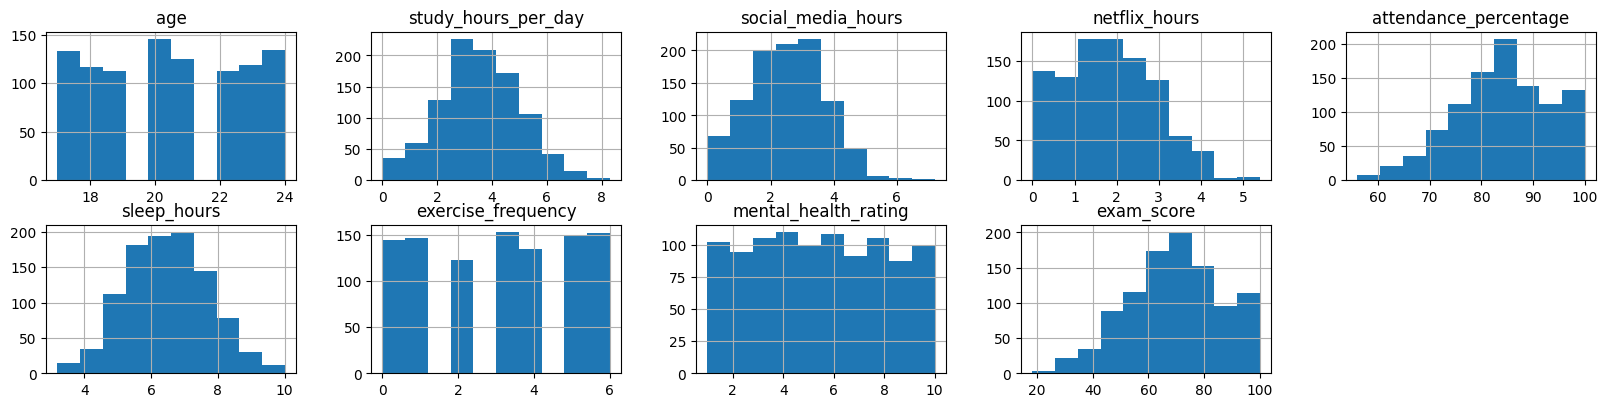

In [ ]:
plot = num_data.hist(figsize = (20,22), layout=[9,5]) # Criação de um histograma para cada atributo numérico

Uma curta investigação dos histogramas permite observar a existência de padrões aproximadamente normais (gaussianos) em atributos como `study_hours_per_day`, `social_media_hours`, `sleep_hours` e, até mesmo, em `exam_score`. As implicações dessas características serão discutidas no próximo tópico (*2.3. Levantamento de Hipóteses com EDA*).

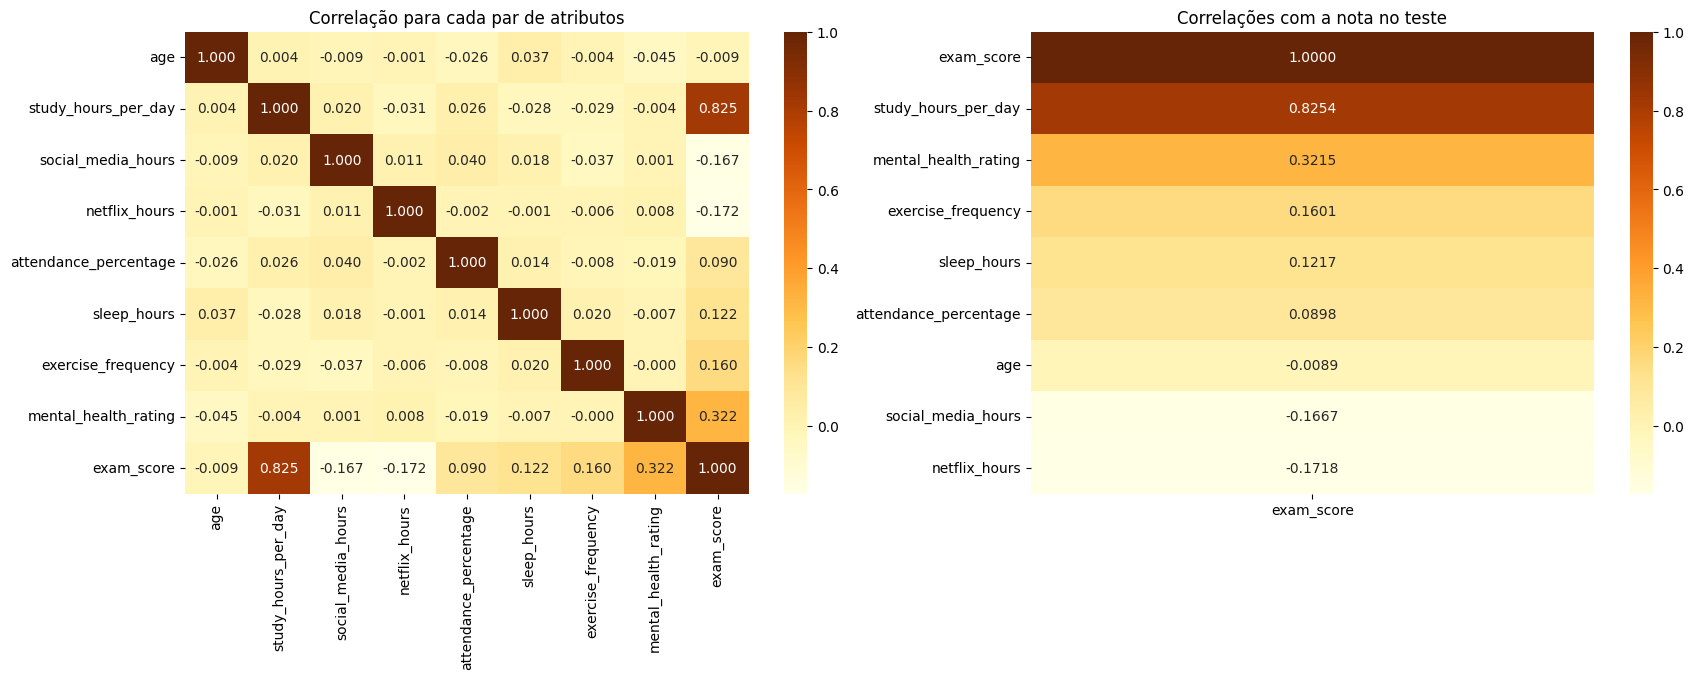

In [ ]:
# Visualização de correlações do dataset codificado

fig, axes = plt.subplots(1, 2, figsize=(20, 6)) # Criação do subplot

# Heatmap para correlações gerais
sns.heatmap(num_data.corr(), annot=True, cmap='YlOrBr', fmt=".3f", ax=axes[0])
axes[0].set_title('Correlação para cada par de atributos')

# Heatmap para correlações com "quality"
sns.heatmap(num_data.corr()[['exam_score']].sort_values(by='exam_score', ascending=False),
            annot=True, cmap='YlOrBr', fmt=".4f", ax=axes[1])
axes[1].set_title('Correlações com a nota no teste')

plt.show() # Visualização do subplot

Com o método `corr`, do próprio *pandas DataFrame*, junto com `heatmaps`, da biblioteca "*Seaborn*", é possível visualizar um mapa de calor que apresenta as *Correlações de Pearson* pra cada par de atributos numéricos do *Dataset*, bem como um que destaca as correlações associadas à `exam_score`.

Evidentemente, o atributo `study_hours_per_day`, seguido de `mental_health_rating`, é o que mais impacta diretamente no aumento do `exam_score`. Essa observação será discutida no próximo tópico (*2.3. Levantamento de Hipóteses com EDA*).

### 2.3. Levantamento de Hipóteses com EDA

Antes de prosseguir para a construção do modelo de clusterização, é importante levantar hipóteses com base em uma *Análise Exploratória de Dados* (*EDA*) simplificada, realizada ao longo do último tópico através de duas tabelas, um histograma e dois *heatmaps*. O objetivo será comparar as hipóteses com os resultados atestados ao final da análise e visualização do modelo, testando e aprofundando os conhecimentos desenvolvidos.

A seguir, seguem algumas hipóteses sobre a clusterização criadas durante a análise em questão:

- A análise dos histogramas permite a observação de padrões normais na maioria dos atributos. A curva gaussiana divide cada variável em três "quadrantes" visíveis: um relacionado aos dados em torno da média, onde está concentrada a maioria dos dados, e dois nos extremos (à esquerda e à direita), nos quais estão certa minoria dos dados. Dessa forma, não é incorreto assumir que um número de *clusters* igual a 3, cada um correspondendo a um quadrante dos histogramas, seja um bom chute inicial para o valor de `K`;
- Ainda nos histogramas, também é importante verificar que há uma possibilidade de que os dados que sigam uma distribuição parecida (gaussiana) também sigam um padrão nos *clusters*. Isso significa, por exemplo, que, ao observar um aumento em um valor de um centróide para outro, é possível que também se observe um aumento nos outros valores cuja distribuição do atributo é semelhante;
- De forma semelhante à última hipótese, também espera-se que não haja um padrão relacionado às variáveis sem uma distribuição definida (como `age` e `exercise_frequency`) no que tange aos diferentes *clusters*;
- No contexto dos *heatmaps*, é perceptível que existe uma grande correlação entre `exam_scote` e os atributos `study_hours_per_day` e `mental_health_rating`, bem como uma certa correlação inversa com `netflix_hours`. Isso significa que, analisando os diferentes *clusters*, se for observada uma variação em uma dessas variáveis, também espera-se uma variação correlacionada com as outras.

## **3. Clusterização com K-Means**

O modelo *K-Means* é um modelo de aprendizado não-supervisionado de clusterização. Isso significa que ele é capaz de atribuir rótulos (clusters) a cada dado, sem a necessidade de um *label* durante o treinamento. Seu funcionamento se dá com base no cálculo da distância euclidiana entre um ponto multi-dimensional e o chamado "centróide", que corresponde ao ponto médio de um *cluster*.

De forma resumida, o funcionamento do modelo *K-Means* se dá nas seguintes etapas:

- Definição de `K`: Estabelece o número de clusters ("*K*"), a partir de alguma estratégia como *EDA* ou *Método do Cotovelo*;
- Inicialização: Dispõe coordenadas aleatórias aos `K` centróides iniciais;
- Loop de treinamento:
  - Atribuição: Atribui cada ponto a um cluster, com base no centróide mais próximo;
  - Atualização: Calcula as coordenadas dos novos centróides com base na média dos pontos de cada *cluster*;
  - Verificação: Apura se o modelo atingiu a tolerância e dá prosseguimento ou encerra o *loop*.

Neste desenvolvimento, será construída, em *3.1. Importação de Bibliotecas e Definição de Classes*, uma versão *from scratch* do *K-Means*, isto é, sem o auxílio de bibliotecas prontas para a elaboração do modelo. Será utilizada apenas a biblioteca `numpy`, para cálculos euclidianos e manipulação de vetores. Além disso, no mesmo tópico, será elaborada também uma classe para o *Método do Cotovelo* a fim de definir, em "*3.3. Execução do Método do Cotovelo*", um valor ideal para `K`.

### 3.1. Importação de Bibliotecas e Definição de Classes

In [ ]:
from sklearn.preprocessing import StandardScaler # Normalização de dados
from sklearn.decomposition import PCA # Redução de dimensionalidade

In [ ]:
# Modelo K-Means from scratch
class KMeans():
  # Método de inicialização de atributos
  def __init__(self, k=3, max_iters=100, tolerance=1e-6):
    self.k = k # Número de clusters
    self.max_iters = max_iters # Número máximo de iterações
    self.tolerance = tolerance # Tolerância para convergência

  # Inicializa e itera o cálculo dos centróides, até que a tolerância seja satisfeita
  def fit(self, X):
    np.random.seed(42) # Define a semente aleatória para reprodutibilidade
    self.centroids = X[np.random.choice(len(X), self.k, replace=False)] # Define os centróides iniciais com base em índices aleatórios

    for i in range(self.max_iters):
      self.labels = self._assign_clusters(X) # Atribui cada ponto ao centróide mais próximo
      old_centroids = self.centroids.copy() # Salva os centróides anteriores para comparação
      self.centroids = self._calculate_centroids(X) # Atualiza os centróides com base nas médias dos grupos

      if np.all(np.linalg.norm(self.centroids - old_centroids, axis=1) < self.tolerance): # Verifica se os centróides mudaram menos que a tolerância
        return np.sum((X - self.centroids[self.labels])**2) # Encerra o loop em caso de convergência e retorna a inércia

  # Atribui um grupo para cada ponto, com base na menor distância euclidiana a um centróide
  def _assign_clusters(self, X):
    distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2) # Calcula as distâncias de cada ponto a cada centróide
    return np.argmin(distances, axis=1) # Retorna o índice do centróide mais próximo para cada ponto

  # Recalcula o valor dos centróides com base na média de cada grupo atual
  def _calculate_centroids(self, X):
    centroids = np.zeros((self.k, X.shape[1])) # Cria um array para armazenar os novos centróides

    for i in range(self.k):
      points = X[self.labels == i] # Seleciona todos os pontos atribuídos ao cluster i
      centroids[i] = np.mean(points, axis=0) if len(points) > 0 else 0 # Calcula a média dos pontos no cluster i

    return centroids # Retorna os novos centróides

In [ ]:
# Método do Cotovelo from scratch
class ElbowMethod():
  # Método de inicialização de atributos
  def __init__(self, max_K):
    self.K_range = list(range(1, max_K+1)) # Inicializa o range de valores de K

  # Calcula o SSE (Sum of Squared Errors) para cada valor de K
  def fit(self, X):
    sse_list = [] # Armazenará os SSE de cada K

    for k in self.K_range: # Loop para diferentes valores de K
      kmeans = KMeans(k=k) # Instancia o KMeans com o valor atual de K
      sse = kmeans.fit(X) # Treina o modelo para o k atual e adquire seu SSE
      sse_list.append(sse) # Armazena o SSE calculado na lista

    return sse_list  # Retorna a lista com todos os SSE

  # Calcula o melhor valor de K com base na "distância ao segmento"
  def best_k(self, sse):
    p1, p2 = np.array([self.K_range[0], sse[0]]), np.array([self.K_range[-1], sse[-1]]) # Define os pontos extremos da curva
    line = p2 - p1 # Vetor da linha base entre os pontos extremos
    dist = lambda p: np.abs(np.cross(line, p - p1)) / np.linalg.norm(line) # Função para distância perpendicular de um ponto à linha base
    dists = [dist(np.array([k, e])) for k, e in zip(self.K_range, sse)] # Calcula essa distância para cada ponto (k, sse[k])

    return self.K_range[np.argmax(dists)] # Retorna K para o ponto com maior distância (o "cotovelo")

  # Plota o gráfico Inércia X K, com uma linha indicativa do melhor K
  def plot(self, k, sse):
    plt.plot(self.K_range, sse, marker='o')
    plt.axvline(k, color='red', linestyle='--', label=f'Best K = {k}')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia (Sum of Squared Errors)')
    plt.title('Elbow Method Visualization')
    plt.legend()
    plt.grid(True)
    plt.show()

### 3.2. Normalização dos Atributos Numéricos


O modelo *K-Means*, por trabalhar com cálculos diretamente com as coordenadas dos pontos, ao comparar valores subordinados a diferentes escalas, pode causar imprecisão ou censura nos resultados. Por isso, ele traz consigo a necessidade de normalização dos números.

A normalização é um processo que redefine os valores de diferentes atributos, de forma que variem dentro de um mesmo intervalo (com *μ* = 0 e *σ* = 1), sem afetar possíveis relações entre os dados. Isso garante que a diferença entre a escala dos atributos não traga prejuízos para os cálculos executados pelo modelo.

In [ ]:
# Normalização dos dados numéricos
scaler = StandardScaler() # Instancia o normalizador
num_data_scaled = scaler.fit_transform(num_data) # Normaliza os dados numéricos em "num_data_scaled"

### 3.3. Execução do *Método do Cotovelo*

O *Método do Cotovelo*, ou *Elbow's Method*, é uma técnica de otimização que funciona em conjunto com o modelo de clusterização *K-Means*. Seu objetivo é proporcionar uma análise que leve a um valor ideal de `K`, ou número de centróides.

Seu funcionamento se dá a partir de `max_K` execuções do *K-Means*, variando a quantidade de centróides. Para cada `K`, extrai-se a métrica *inércia*, também chamada de *inertia* ou *SSE* (*Sum of Squared Errors*), a qual é transcrita para um gráfico comparativo. Esta, corresponde a uma métrica de avaliação baseada na soma das distâncias dos pontos aos centróides.

Seguindo a linha do *Método do Cotovelo*, a próxima etapa seguindo a plotagem das inércias é a análise do gráfico para identificar um valor ideal de `K`. Nesse sentido, busca-se um valor não muito alto, a fim de evitar **perda de generalização** (*overfitting*), mas também não muito baixo, a fim de **garantir a categorização** desejada. Para isso, deve ser selecionado um ponto no qual há uma diminuição drástica na variação da inércia, formando um "cotovelo" no gráfico.

Para automatizar essa seleção, há a abordagem geométrica utilizando a "*linha base*", ou "*distância ao segmento*". Nela, seleciona-se o ponto com a maior distância ortogonal da linha que liga os pontos extremos do gráfico. Dessa maneira, a interpretação permite que o sistema selecione as coordenadas que houveram maior queda de variação.

<ipython-input-26-a1e429a3c60c>:22: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = lambda p: np.abs(np.cross(line, p - p1)) / np.linalg.norm(line) # Função para distância perpendicular de um ponto à linha base


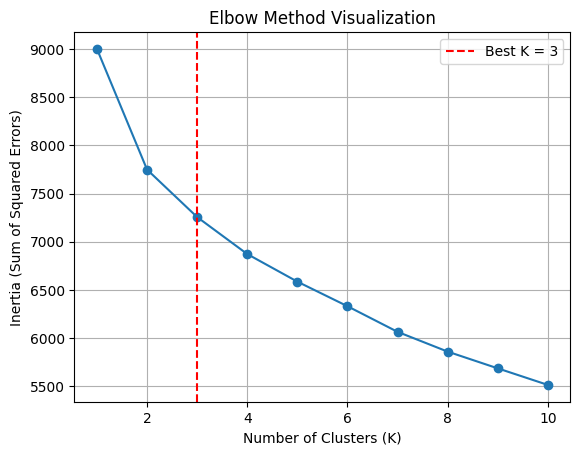

In [ ]:
# Aplicação do Método do Cotovelo
elbow_method = ElbowMethod(max_K=10) # Inicializa a classe para o Método do Cotovelo
sse_list = elbow_method.fit(num_data_scaled) # Armazena a lista com os SSE
best_k = elbow_method.best_k(sse_list) # Armazena o melhor valor de K
elbow_method.plot(best_k, sse_list) # Plota o gráfico Inércia X K

Após a construção do gráfico que representa a execução do *Método do Cotovelo* para o modelo *K-Means* com a subdivisão normalizada do *Dataset* original, sem os atributos categóricos, além da aplicação da *distância ao segmento* para definir o ponto "cotovelo" no gráfico, conclui-se que o `K` ideal, associado a uma inércia de aproximadamente `7.250`, é `K = 3`.

### 3.4. Criação do Modelo e Redimensionalização

Aqui, é criado, na variável `kmeans`, e treinado, com o método `fit`, o modelo *K-Means* com o valor otimizado (`K = 3`) referente ao número de centróides e de *clusters*.

In [ ]:
# Criação do K-Means otimizado
kmeans = KMeans(k=best_k) # Cria o modelo com o melhor K
inertia = kmeans.fit(num_data_scaled) # Treina o modelo, definindo os centróides
print(f'Inércia para K={best_k}: {inertia}') # Printa a inércia, para o K definido

Inércia para K=3: 7255.846654901241


Com o modelo "em mãos", prossegue-se para uma redimensionalização dos dados, utilizando a PCA.

A *PCA* (*Principal Component Analysis*) é uma técnica comum de redução de dimensionalidade em conjunto de dados. De forma resumida, ela transforma o conjunto de variáveis em um novo conjunto de variáveis não correlacionadas. Aqui, ela será utilizada para a visualização do *Dataset* (com 9 dimensões) em um gráfico bidimensional (`PCA X` x `PCA Y`)

In [ ]:
# Redução de dimensionalidade do Dataset
pca = PCA(n_components=2) # Cria o PCA com 2 componentes
pca_data = pca.fit_transform(num_data_scaled) # Aplica o PCA nos atributos numéricos normalizados
pca_centroids = pca.transform(kmeans.centroids) # Também aplica o PCA nos centróides já definidos

### 3.5. Visualização dos Resultados

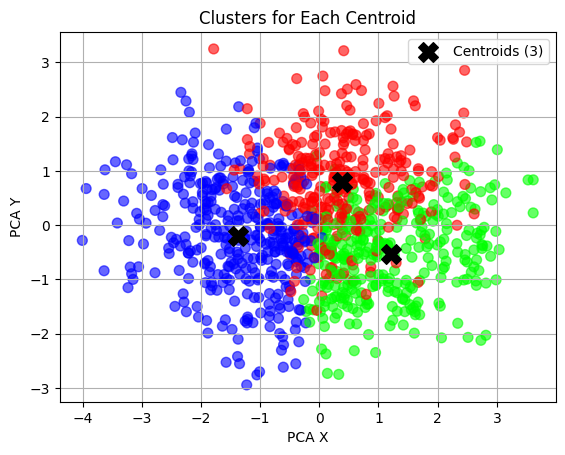

In [ ]:
# Exibição de um gráfico 2D para os eixos PCA
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans.labels, cmap='brg', alpha=0.6, s=50)
plt.scatter(pca_centroids[:, 0], pca_centroids[:, 1], c='black', marker='X', s=200, label=f'Centroids ({best_k})')
plt.title("Clusters for Each Centroid")
plt.xlabel("PCA X")
plt.ylabel("PCA Y")
plt.legend()
plt.grid(True)
plt.show()

A plotagem do gráfico com os eixos PCA permite a visualização resumida do resultado do modelo, destacando os centróides com `X` e os clusters com as cores **azul** (*Cluster 1*), **vermelho** (*Cluster 2*) e **verde** (*Cluster 3*).

É perceptível como o modelo parece ter tido um desempenho aceitável-alto, de forma que os *clusters* sejam visíveis e diferenciáveis no "olhômetro". Em sequência, é importante explorar as informações dos centróides com uma tabela:

In [ ]:
# Exibição uma tabela com os centróides para cada atributo do Dataset

unorm_centroids = scaler.inverse_transform(kmeans.centroids) # Desfaz a normalização, para visualização na tabela

colors = plt.cm.brg(np.linspace(0, 1, len(pca_centroids))) # Separa o RGB das cores dos centróides
row_styles = [{'selector': f'th.row{i}', 'props': [('background-color', color)]} # Armazena as cores dos centróides
              for i, color in enumerate([matplotlib.colors.rgb2hex(c) for c in colors])] # Loop para cada cor em Hexadecimal

df_centroids = pd.DataFrame(unorm_centroids, columns=num_data.columns) # Cria um DataFrame que relaciona centróides e atributos
df_centroids["PCA X"], df_centroids["PCA Y"] = pca_centroids[:, 0], pca_centroids[:, 1] # Calcula os centróides para os eixos PCA
df_centroids = df_centroids[["PCA X", "PCA Y"] + num_data.columns.tolist()] # Reordena para exibir PCA's primeiro

df_centroids.index = [f"Centroid {i+1}" for i in range(len(unorm_centroids))] # Define o nome das linhas
df_centroids.style.format("{:.3f}").set_table_styles(row_styles, overwrite=False) # Define o formato e estilo das células

,PCA X,PCA Y,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,exam_score
Centroid 1,-1.374,-0.197,20.727,2.284,2.548,2.102,83.095,6.444,3.173,4.203,53.178
Centroid 2,0.391,0.793,19.716,4.164,2.916,1.752,84.920,6.005,1.574,6.297,74.031
Centroid 3,1.210,-0.540,20.991,4.419,2.059,1.558,84.567,6.951,4.313,6.034,84.300


Na tabela acima, estão exibidas as correspondências desnormalizadas dos 3 centróides calculados pelo modelo com cada atributo numérico, além dos dois eixos PCA. É importante mencionar que esses dados não necessariamente existem no *Dataset*, uma vez que são calculados a partir das médias dos pontos do *cluster*.

A análise permite inferir a correlação entre atributos de um mesmo *cluster*, a fim de compreender as características dos 3 grupos de alunos separados, conforme será abordado em *4. Revisão de Hipóteses*.

## **4. Revisão de Hipóteses**

Após o desenvolvimento, otimização e apresentação dos resultados do modelo, é importante revisar as hipóteses iniciais sobre o *Dataset*, realizadas em *2.3. Levantamento de Hipóteses com EDA*, com os dados concretos a respeito dos *clusters*. A seguir, apresentam-se as observações relevantes:

- O número de centróides `K = 3` foi uma excelente escolha e refletiu um agrupamento satisfatório dos estudantes;
- Com relação aos atributos com distribuição semelhante, houve resultados mistos. Ao mesmo tempo que variáveis como `age`, cuja distribuição não parecia apontar para uma correlação com os *clusters*, o que foi atestado, assim como variáveis como `study_hours_per_day` e `exam_score`, as quais seguiram um padrão de aumento do *cluster* `1` para o `3`, variáveis como `social_media_hours` não trouxeram o padrão esperado entre *clusters*;
- No que tange aos *heatmaps* de correlação, esperava-se um mesmo padrão de aumento entre os centróides para `exam_score` e `study_hours_per_day`, e um padrão inverso para `netflix_hours`. Conforme observado na tabela, esses resultados foram atestados, e a relação realmente existe;
- Fora do escopo das hipóteses iniciais, observa-se que atributos como `social_media_hours`, `attendance_percentage` e `mental_health_rating` trouxeram um aumento no segundo centróide, o que significa que indivíduos com `exam_score` intermediário tendem a se destacar nesses atributos.

## **5. Conclusão**

Após as etapas desenvolvidas, dentre as quais se destacam: **análise do *dataset***, **levantamento de hipóteses**, **construção do modelo**, **normalização**, **otimização de `K`**, **redução de dimensionalidade com PCA**, **análise de resultados** e **revisão de hipóteses**, foi desenvolvida uma abordagem rica durante a aplicação de um modelo de aprendizado não-supervisionado.

Assim, com base nos diagnósticos obtidos, é possível concluir que o modelo *K-Means* obteve um resultado satisfatório (conforme indicado no gráfico de PCA's e no baixo valor da inércia) e que a clusterização seguiu uma boa parte das teorias inicialmente desenvolvidas com base no estudo do conjunto de dados.

## **6. Bibliografia**

- 1. **Student Habits vs Academic Performance**. Kaggle. Disponível em: https://www.kaggle.com/datasets/jayaantanaath/student-habits-vs-academic-performance. Acesso em: 20 maio 2025.
- 2. KAVLAKOGLU, E; WINLAND, V. **What is k-means clustering?** International Business Machines Corporation. Disponível em: https://www.ibm.com/think/topics/k-means-clustering. Acesso em: 20 maio 2025.
- 3. TOMAR, A. **Elbow Method in K-Means Clustering: Definition, Drawbacks, vs. Silhouette Score**. Built In. Disponível em: https://builtin.com/data-science/elbow-method. Acesso em: 20 maio 2025.
- 4. GREENACRE, M. *et al.* **Principal Component Analysis**. Nature. Disponível em: https://www.nature.com/articles/s43586-022-00184-w. Acesso em: 21 maio 2025.